In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd '/content/drive/MyDrive/DataScience/Spleen'
!ls

/content/drive/MyDrive/DataScience/Spleen
2D_Segmentation  3D_Spleen.zip	       NoteBooks
2D_Spleen.zip	 MONAI_DATA_DIRECTORY  Task09_Spleen


## Setup environment

In [ ]:
#0.5.3 version
!python -c "import monai" || pip install 'monai==0.5.3'
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

Traceback (most recent call last):
  File "<string>", line 1, in <module>
ModuleNotFoundError: No module named 'monai'
     |████████████████████████████████| 497 kB 7.4 MB/s 


In [ ]:
#newest version
!python -c "import monai" || pip install -q "monai-weekly[gdown, nibabel, tqdm]"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

# Prepare Data format with below format and structure:
1. Create 2 sub-folder: **imagesTr and labelsTr** (for train and validation set)
2. 3D volume data(image and mask) for any subjects must be nifti format(.nii or .nii.gz) with slice in **axis=2**
3. The images must be in the imagesTr folder
4. The segmentation masks must be in the labelsTr folder
5. The test-set must be in the imagesTe and labelsTe folders if If we have a test set

In [ ]:
!zip -r "../3D_Spleen.zip" "3D_Spleen"

	zip warning: name not matched: 3D_Spleen

zip error: Nothing to do! (try: zip -r ../3D_Spleen.zip . -i 3D_Spleen)


## unzip

In [ ]:
# unzip raw data into the "MONAI_DATA_DIRECTORY"
import shutil
shutil.unpack_archive("3D_Spleen.zip", "MONAI_DATA_DIRECTORY")

# Import Modules and functions
# Setup imports

In [ ]:
# Import Molule and functios
from monai.utils import first, set_determinism
from monai.transforms import (
    AsDiscrete,
    AddChanneld,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandCropByPosNegLabeld,
    ScaleIntensityRanged,
    Spacingd,
    ToTensord,
)

from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.metrics import compute_meandice
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.data import CacheDataset, DataLoader, Dataset
from monai.config import print_config
from monai.apps import download_and_extract
import torch
import matplotlib.pyplot as plt
import tempfile
import shutil
import os
import numpy as np
import glob

print_config()

MONAI version: 0.5.3
Numpy version: 1.19.5
Pytorch version: 1.9.0+cu102
MONAI flags: HAS_EXT = False, USE_COMPILED = False
MONAI rev id: d78c669c67e38ddfbe572f6a0438e9df0b8c65d7

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 3.0.2
scikit-image version: 0.16.2
Pillow version: 7.1.2
Tensorboard version: 2.5.0
gdown version: 3.6.4
TorchVision version: 0.10.0+cu102
ITK version: NOT INSTALLED or UNKNOWN VERSION.
tqdm version: 4.41.1
lmdb version: 0.99
psutil version: 5.4.8

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



In [ ]:
root_dir = 'MONAI_DATA_DIRECTORY'
data_dir = os.path.join(root_dir,"3D_Spleen")
print(data_dir)

MONAI_DATA_DIRECTORY/3D_Spleen


# New Section

## random Split and Set dataset path

- 80% for train set
- 20% validation set
- Data path must be saved in dictionary formats

for example :
[{'image': './MONAI_DATA_DIRECTORY/3D_Spleen/imagesTr/35.nii',
  'label': './MONAI_DATA_DIRECTORY/3D_Spleen/labelsTr/35.nii'},
 {'image': './MONAI_DATA_DIRECTORY/3D_Spleen/imagesTr/2.nii',
  'label': './MONAI_DATA_DIRECTORY/3D_Spleen/labelsTr/2.nii'}]

In [ ]:
from sklearn.model_selection import train_test_split

train_images = sorted(
    glob.glob(os.path.join(data_dir, "imagesTr", "*.nii.gz")))
train_labels = sorted(
    glob.glob(os.path.join(data_dir, "labelsTr", "*.nii.gz")))
data_dicts = [
    {"image": image_name, "label": label_name}
    for image_name, label_name in zip(train_images, train_labels)
]

In [ ]:
#train_files, val_files = train_test_split(data_dicts ,test_size=0.2, random_state=0)
#fold1 :
#train_files, val_files = data_dicts[:-9], data_dicts[-9:] 
#fold5 :
train_files = data_dicts[:17]+data_dicts[25:] 
val_files = data_dicts[17:25]

In [ ]:
len(val_files)

8

## Set deterministic training for reproducibility

In [ ]:
set_determinism(seed=0)

## Setup transforms for training and validation

Here we use several transforms to augment the dataset:
1. `LoadImaged` loads the CT images and labels from NIfTI format files.
2. `AddChanneld` as the original data doesn't have channel dim, add 1 dim to construct "channel first" shape.
1. `Spacingd` adjusts the spacing by `pixdim=(1.5, 1.5, 2.)` based on the affine matrix.
 - for example (512,512,150) reshape to (300,250,150)
 - pixdim=(1.5, 1.5, 2.) -> (1.5mm, 1.5mm, 2.mm)
1. `Orientationd` unifies the data orientation based on the affine matrix.
 - axcodes (Optional[str]) – N elements sequence for spatial ND input’s orientation. e.g. axcodes=’RAS’ represents 3D orientation: (Left, Right), (Posterior, Anterior), (Inferior, Superior). default orientation labels options are: ‘L’ and ‘R’ for the first dimension, ‘P’ and ‘A’ for the second, ‘I’ and ‘S’ for the third.

1. `ScaleIntensityRanged` extracts intensity range [-1024, 150] and scales to [0, 1].
  - [-1024, 150] -> for scaling biomedical image data by window level (WL =-600) and width (WW =1500)
1. `CropForegroundd` removes **all zero borders** to focus on the valid body area of the images and labels.
1. `RandCropByPosNegLabeld` randomly crop patch samples from big image based on **pos / neg** ratio.  
The image centers of negative samples must be in valid body area.
1. `RandAffined` efficiently performs `rotate`, `scale`, `shear`, `translate`, etc. together based on PyTorch affine transform.(We did not use it)
1. `ToTensord` converts the numpy array to PyTorch Tensor for further steps.

---

In [ ]:
train_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        AddChanneld(keys=["image", "label"]),
        Spacingd(keys=["image", "label"], pixdim=(
            1.5, 1.5, 2), mode=("bilinear", "nearest")), #1.5,1.5,2
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        ScaleIntensityRanged(
            keys=["image"], a_min=-30, a_max=210, #-30,210
            b_min=0.0, b_max=1.0, clip=True,
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
     
        RandCropByPosNegLabeld(
           keys=["image", "label"],
            label_key="label",
            spatial_size= (96, 96, 96),
            pos=1,
            neg=1,
            num_samples=4,
            image_key="image",
            image_threshold=0,
        ),
     
        # user can also add other random transforms
        # RandAffined(
        #     keys=['image', 'label'],
        #     mode=('bilinear', 'nearest'),
        #     prob=1.0, spatial_size=(96, 96, 96),
        #     rotate_range=(0, 0, np.pi/15),
        #     scale_range=(0.1, 0.1, 0.1)),
        ToTensord(keys=["image", "label"]),
    ]
)
val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        AddChanneld(keys=["image", "label"]),
        Spacingd(keys=["image", "label"], pixdim=(
            1.5, 1.5, 2), mode=("bilinear", "nearest")),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        ScaleIntensityRanged(
            keys=["image"], a_min=-30, a_max=210, 
            b_min=0.0, b_max=1.0, clip=True,
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        ToTensord(keys=["image", "label"]),
    ]
)

## Create DataSets

In [ ]:
check_ds = Dataset(data=val_files, transform=val_transforms)
check_loader = DataLoader(check_ds, batch_size=1)
check_data = first(check_loader)
aaa = check_data["image"]
labelaaa = check_data["label"]
print(f"image shape: {aaa.shape}, label shape: {labelaaa.shape}")

image shape: torch.Size([1, 1, 283, 236, 256]), label shape: torch.Size([1, 1, 283, 236, 256])


## Check transforms in DataLoader

image shape: torch.Size([1, 1, 283, 236, 256]), label shape: torch.Size([1, 1, 283, 236, 256])
image shape: torch.Size([283, 236, 256]), label shape: torch.Size([283, 236, 256])


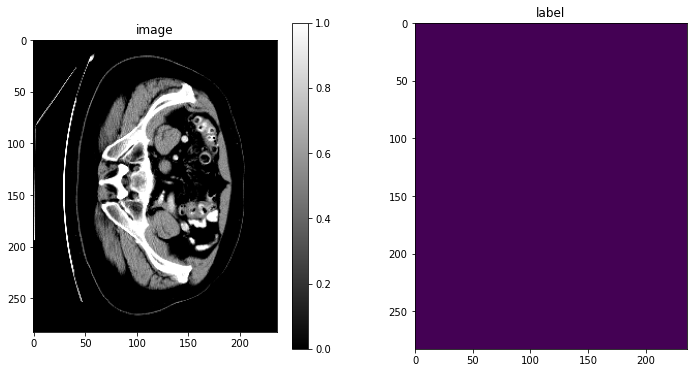

In [ ]:
check_ds = Dataset(data=val_files, transform=val_transforms)
check_loader = DataLoader(check_ds, batch_size=1)
check_data = first(check_loader)
aaa = check_data["image"]
labelaaa = check_data["label"]
print(f"image shape: {aaa.shape}, label shape: {labelaaa.shape}")
image, label = (check_data["image"][0][0], check_data["label"][0][0])
print(f"image shape: {image.shape}, label shape: {label.shape}")
plt.figure("check", (12, 6))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(image[:, :, 70], cmap="gray")
plt.colorbar()
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(label[:, :, 70])
plt.show()

## Define CacheDataset and DataLoader for training and validation

Here we use CacheDataset to accelerate training and validation process, it's 10x faster than the regular Dataset.  
To achieve best performance, set `cache_rate=1.0` to cache all the data, if memory is not enough, set lower value.  
Users can also set `cache_num` instead of `cache_rate`, will use the minimum value of the 2 settings.  
And set `num_workers` to enable multi-threads during caching.  
If want to to try the regular Dataset, just change to use the commented code below.

# Dataloader batch_size
- Use batch_size=2 to load images and use RandCropByPosNegLabeld to generate 2 x 4 images for network training


In [ ]:
train_ds = CacheDataset(
    data=train_files, transform=train_transforms,
    cache_rate=1.0, num_workers=4)

train_loader = DataLoader(train_ds, batch_size=2, shuffle=True, num_workers=4)

/usr/local/lib/python3.7/dist-packages/monai/data/dataset.py:540: UserWarning: tqdm is not installed, will not show the caching progress bar.
  warnings.warn("tqdm is not installed, will not show the caching progress bar.")
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
val_ds = CacheDataset(
    data=val_files, transform=val_transforms, cache_rate=1.0, num_workers=4)


val_loader = DataLoader(val_ds, batch_size=1,num_workers=4) 

/usr/local/lib/python3.7/dist-packages/monai/data/dataset.py:540: UserWarning: tqdm is not installed, will not show the caching progress bar.
  warnings.warn("tqdm is not installed, will not show the caching progress bar.")
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


# load first batch of data_loader and print shape of batch-data.

In [ ]:
for batch_data in train_loader:
    inputs, labels = (
        batch_data["image"],
        batch_data["label"],
    )
    break
inputs.shape,labels.shape

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


(torch.Size([8, 1, 96, 96, 96]), torch.Size([8, 1, 96, 96, 96]))

In [ ]:
for val_data in val_loader:
    val_inputs, val_labels = (
        val_data["image"],
        val_data["label"],
    )
    break
val_inputs.shape,val_labels.shape

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


(torch.Size([1, 1, 283, 236, 256]), torch.Size([1, 1, 283, 236, 256]))

## Create Model, Loss, Optimizer
- standard PyTorch program style: create UNet, DiceLoss and Adam optimizer

In [ ]:
device = torch.device("cuda:0")
model = UNet(
    dimensions=3,
    in_channels=1,
    out_channels=2,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,
    norm=Norm.BATCH,
    
).to(device)
loss_function = DiceLoss(to_onehot_y=True, softmax=True)


In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

## Execute a typical PyTorch training process

- Notice! roi_size in sliding_window_inference Is a multiple of 32
 for example(96,96,96) or (192,192,192), etc.

In [ ]:
#max_epochs = 50
max_epochs = 10  #num of epochs till now counting current epoch = 400 epochs
val_interval = 2
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []
post_pred = AsDiscrete(argmax=True, to_onehot=True, n_classes=2)
post_label = AsDiscrete(to_onehot=True, n_classes=2)


In [ ]:
model.load_state_dict(torch.load(os.path.join(
                    root_dir, "best_metric_model3.pth")))
model.eval()

UNet(
  (model): Sequential(
    (0): ResidualUnit(
      (conv): Sequential(
        (unit0): Convolution(
          (conv): Conv3d(1, 16, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
          (adn): ADN(
            (N): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (D): Dropout(p=0.0, inplace=False)
            (A): PReLU(num_parameters=1)
          )
        )
        (unit1): Convolution(
          (conv): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
          (adn): ADN(
            (N): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (D): Dropout(p=0.0, inplace=False)
            (A): PReLU(num_parameters=1)
          )
        )
      )
      (residual): Conv3d(1, 16, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
    )
    (1): SkipConnection(
      (submodule): Sequential(
        (0): ResidualUnit(
          (conv): Sequential(


In [ ]:
for epoch in range(max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
      
        step += 1
        inputs, labels = (
            batch_data["image"].to(device),
            batch_data["label"].to(device),
        )
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)    
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        # print(
        #     f"{step}/{len(train_ds) // train_loader.batch_size}, "
        #     f"train_loss: {loss.item():.4f}")
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            metric_sum = 0.0
            metric_count = 0
            for val_data in val_loader:
                val_inputs, val_labels = (
                    val_data["image"].to(device),
                    val_data["label"].to(device),
                )
                roi_size = (160, 160, 160) #128,96,192,224   #initial:160
                sw_batch_size = 4
                val_outputs = sliding_window_inference(
                    val_inputs, roi_size, sw_batch_size, model)
                val_outputs = post_pred(val_outputs)
                val_labels = post_label(val_labels)
                value = compute_meandice(
                    y_pred=val_outputs,
                    y=val_labels,
                    include_background=False,
                )
                metric_count += len(value)
                metric_sum += value.sum().item()
            metric = metric_sum / metric_count
            metric_values.append(metric)
            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                #torch.save(model.state_dict(), os.path.join(
                #    root_dir, "best_metric_model3.pth"))
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
                f"\nbest mean dice: {best_metric:.4f} "
                f"at epoch: {best_metric_epoch}"
            )

----------
epoch 1/10


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


epoch 1 average loss: 0.2194
----------
epoch 2/10
epoch 2 average loss: 0.2033
saved new best metric model
current epoch: 2 current mean dice: 0.9385
best mean dice: 0.9385 at epoch: 2
----------
epoch 3/10
epoch 3 average loss: 0.1844
----------
epoch 4/10
epoch 4 average loss: 0.1827
saved new best metric model
current epoch: 4 current mean dice: 0.9426
best mean dice: 0.9426 at epoch: 4
----------
epoch 5/10
epoch 5 average loss: 0.1710
----------
epoch 6/10
epoch 6 average loss: 0.2114
current epoch: 6 current mean dice: 0.9335
best mean dice: 0.9426 at epoch: 4
----------
epoch 7/10
epoch 7 average loss: 0.1757
----------
epoch 8/10
epoch 8 average loss: 0.1575
saved new best metric model
current epoch: 8 current mean dice: 0.9462
best mean dice: 0.9462 at epoch: 8
----------
epoch 9/10
epoch 9 average loss: 0.1860
----------
epoch 10/10
epoch 10 average loss: 0.2096
current epoch: 10 current mean dice: 0.9428
best mean dice: 0.9462 at epoch: 8


In [ ]:
print(
    f"train completed, best_metric: {best_metric:.4f} "
    f"at epoch: {best_metric_epoch}")

train completed, best_metric: 0.9462 at epoch: 8


## Plot the loss and metric

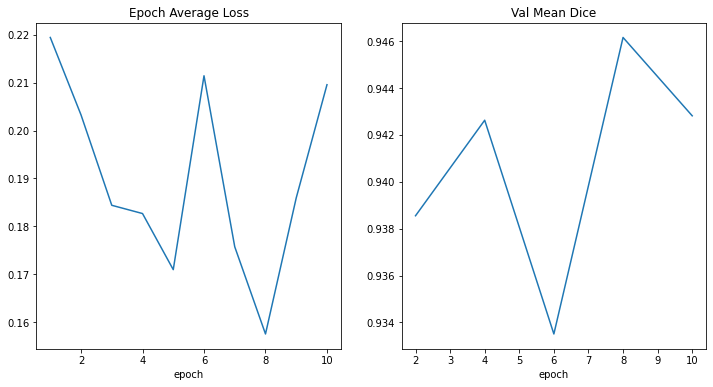

In [ ]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.show()

## Check best model output with the input image and label

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


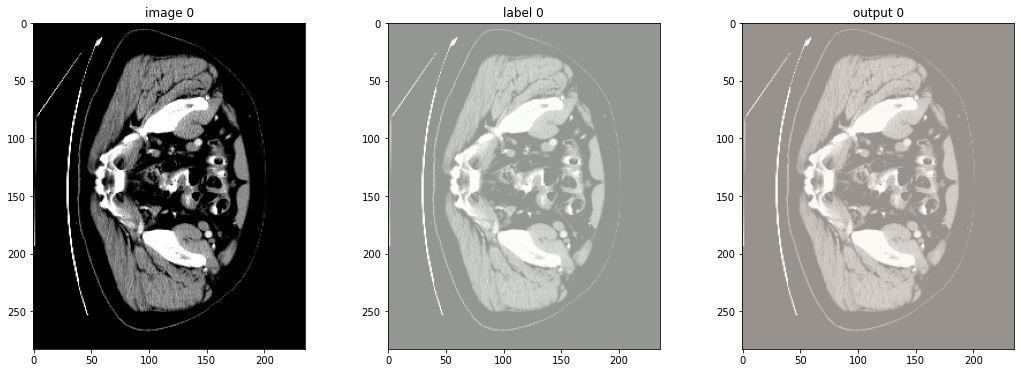

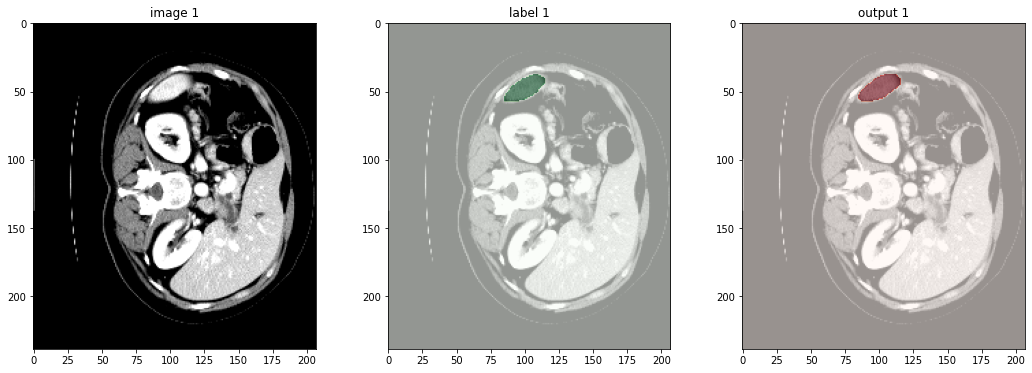

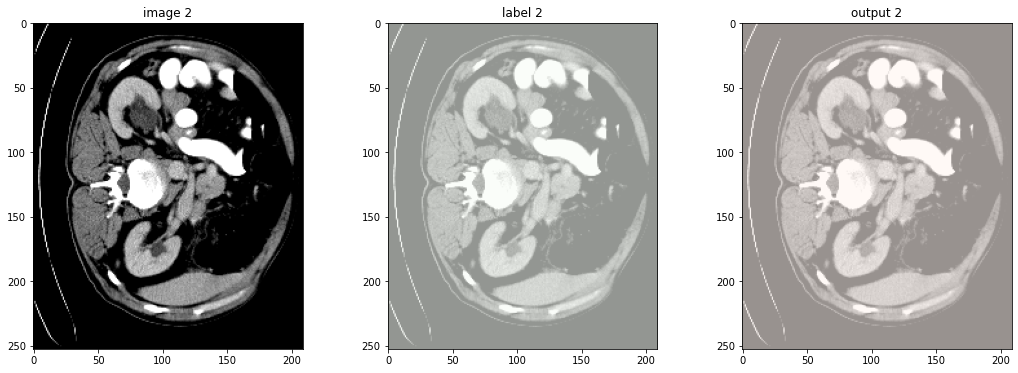

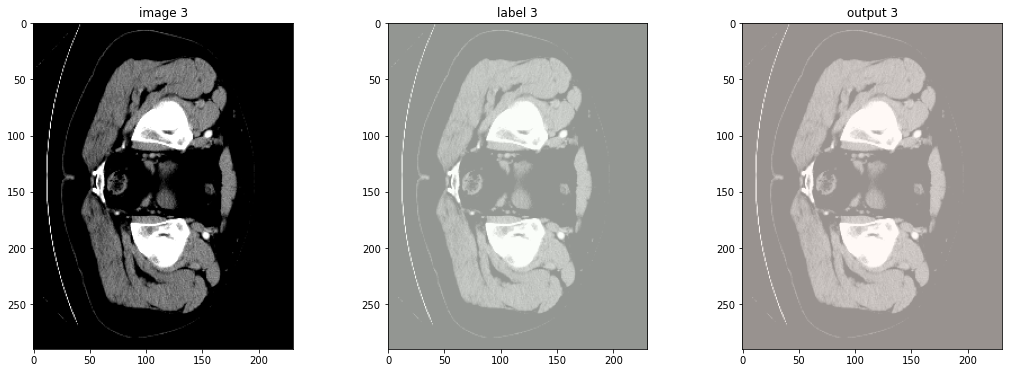

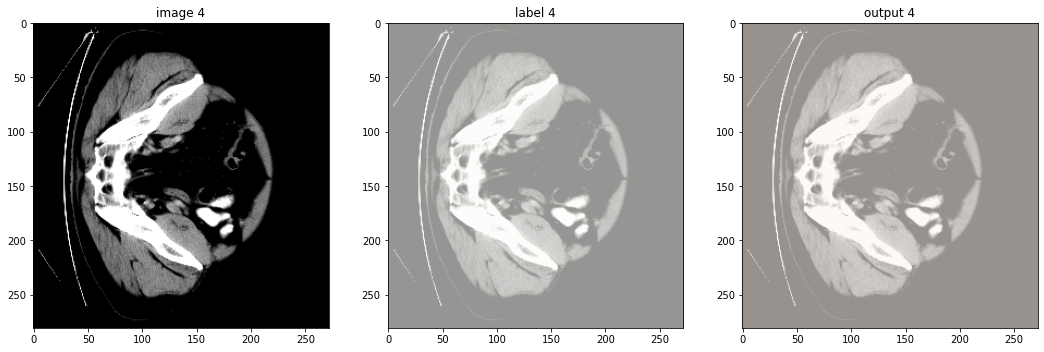

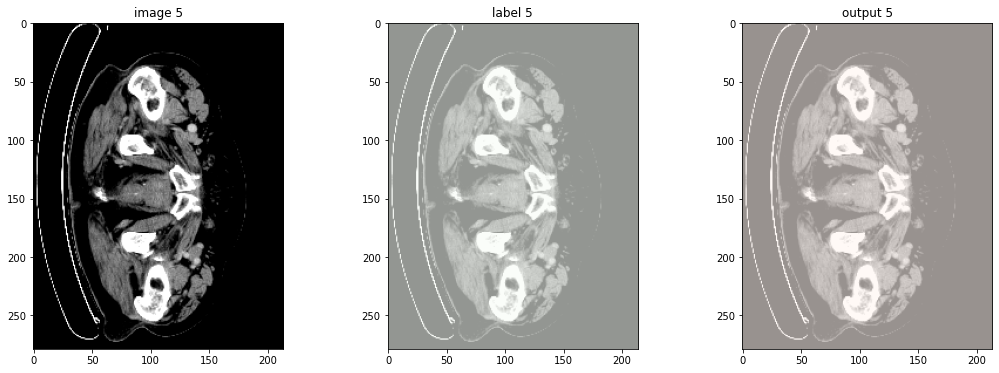

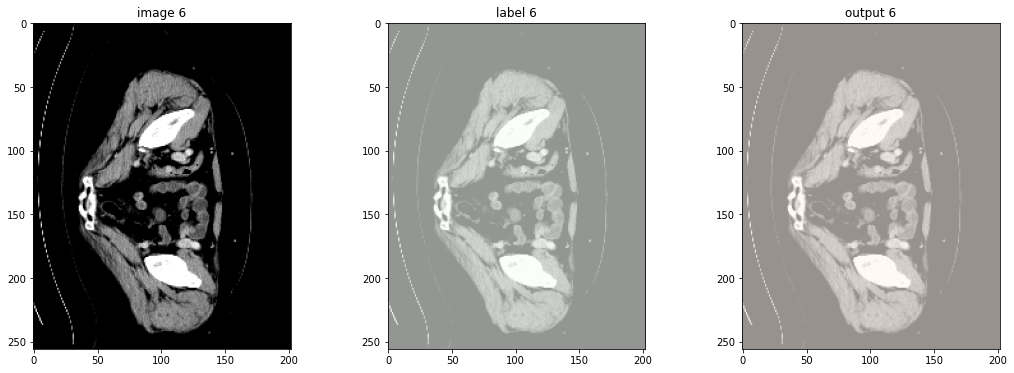

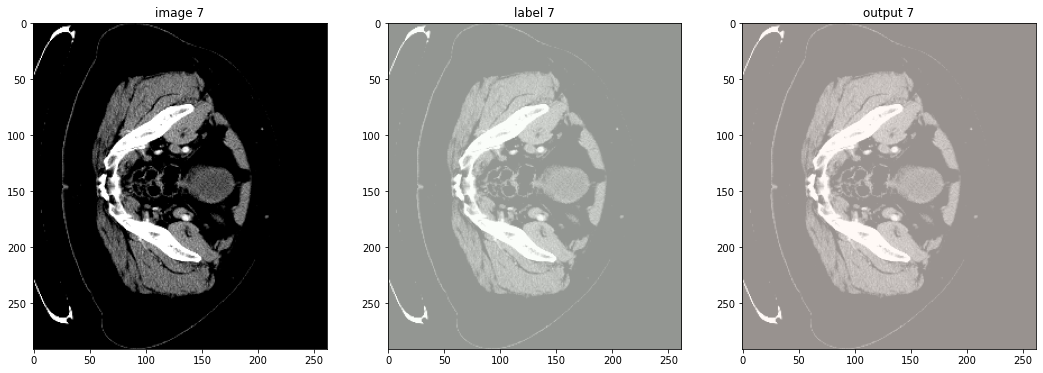

In [ ]:
model.load_state_dict(torch.load(
    os.path.join(root_dir, "best_metric_model1.pth")))
model.eval()
with torch.no_grad():
    for i, val_data in enumerate(val_loader):
        roi_size = (320, 320, 320)
        sw_batch_size = 1
        val_outputs = sliding_window_inference(
            val_data["image"].to(device), roi_size, sw_batch_size, model
        )
        # plot the slice [:, :, 80]
        plt.figure("check", (18, 6))
        plt.subplot(1, 3, 1)
        plt.title(f"image {i}")
        plt.imshow(val_data["image"][0, 0, :, :, 50], cmap="gray")
        plt.subplot(1, 3, 2)
        plt.title(f"label {i}")
        plt.imshow(val_data["image"][0, 0, :, :, 50], cmap="gray")
        plt.imshow(val_data["label"][0, 0, :, :, 50],alpha=0.6,cmap="Greens")
        plt.subplot(1, 3, 3)
        plt.title(f"output {i}")
        plt.imshow(val_data["image"][0, 0, :, :, 50], cmap="gray")
        plt.imshow(torch.argmax(
            val_outputs, dim=1).detach().cpu()[0, :, :, 50],alpha=0.6,cmap="Reds")
        plt.show()